In [1]:
import os
import random
import time
from typing import Tuple

import numpy as np
import torch
import tqdm
from PIL import Image
import cv2 as cv
import numpy
import math
import utils
from nuscenes import NuScenes
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer
from nuscenes.eval.common.utils import quaternion_yaw
from pyquaternion import Quaternion
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.prediction.input_representation.static_layers import correct_yaw
from matplotlib import pyplot as plt
from nuscenes.map_expansion.bitmap import BitMap
import threading
from threading import Thread, Lock
import multiprocessing as mp
from utils import NuscenesUtil

In [2]:
a = torch.tensor([[1, 2], [3, 4], [5, 6]])
t = torch.zeros(2, 2)

In [2]:
nusc = NuScenes(version='v1.0-trainval', dataroot='E:\\nuScenesDataset\\v1.0-trainval_meta', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 62.869 seconds.
Reverse indexing ...
Done reverse indexing in 15.9 seconds.


In [3]:
nusc_map = NuScenesMap(map_name='singapore-hollandvillage', dataroot='E:\\nuScenesDataset\\v1.0-trainval_meta')

map_locs = ['singapore-onenorth', 'singapore-hollandvillage', 'singapore-queenstown', 'boston-seaport']
maps = {item: NuScenesMap(map_name=item, dataroot='E:\\nuScenesDataset\\v1.0-trainval_meta') for item in map_locs}


helper = PredictHelper(nusc)
# static_layer_rasterizer = StaticLayerRasterizer(helper, meters_ahead=80, meters_left=50, meters_right=50)
static_layer_rasterizer = StaticLayerRasterizer(helper)
# agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1, meters_ahead=80, meters_left=50, meters_right=50)
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())
bitmap = BitMap(nusc_map.dataroot, nusc_map.map_name, 'basemap')

In [4]:
challenges = get_prediction_challenge_split('train', 'E:\\nuScenesDataset\\v1.0-trainval_meta')
target_instance_token, sample_token = challenges[900].split('_')
# target_instance_token, sample_token = challenges[200].split('_')
target_ann = helper.get_sample_annotation(target_instance_token, sample_token)

In [11]:
def generate_lanes_information(challenge):
    instance_token, sample_token = challenge.split('_')
    map_name = helper.get_map_name_from_sample_token(sample_token)
    nusc_map = maps[map_name]
    # get the location of target vehicle
    target_ann = helper.get_sample_annotation(instance_token, sample_token)
    target_x, target_y, target_yaw = target_ann['translation'][0], target_ann['translation'][1], NuscenesUtil.get_correct_yaw(target_ann['rotation'])
    # get lane record around the target vehicle
    lanes = NuscenesUtil.get_lanes_in_radius(target_x, target_y, 30, 1, nusc_map)
    result = []
    # transform the lane record to list of coordinate
    for lane_token in lanes:
        coordinates = lanes[lane_token]
        for coordinate in coordinates:
            x, y, yaw = coordinate[0], coordinate[1], coordinate[2]
            x, y, yaw = NuscenesUtil.align_coordinate(target_x, target_y, target_yaw, x, y, yaw)
            result.append(torch.tensor([x, y, yaw]))
    result = torch.stack(result) if len(result) > 0 else torch.tensor([[0, 0, 0]])
    return result

generate_lanes_information(challenges[622]).shape

torch.Size([964, 3])

In [12]:
result = {}
for challenge in tqdm.tqdm(challenges):
    result[challenge] = generate_lanes_information(challenge)


100%|██████████| 32186/32186 [1:38:50<00:00,  5.43it/s]  


In [13]:
torch.save(result, './preprocess_lane_discrete/train.data')

In [14]:
challenges = get_prediction_challenge_split('val', 'E:\\nuScenesDataset\\v1.0-trainval_meta')
result = {}
for challenge in tqdm.tqdm(challenges):
    result[challenge] = generate_lanes_information(challenge)
torch.save(result, './preprocess_lane_discrete/val.data')

100%|██████████| 9041/9041 [24:53<00:00,  6.05it/s]


In [12]:
from visualization_utils import VisualizationUtil

instance_token, sample_token = challenges[0].split('_')
map_name = helper.get_map_name_from_sample_token(sample_token)
nusc_map = maps[map_name]
# get the location of target vehicle
target_ann = helper.get_sample_annotation(instance_token, sample_token)
target_x, target_y, target_yaw = target_ann['translation'][0], target_ann['translation'][1], NuscenesUtil.get_correct_yaw(target_ann['rotation'])
# get lane record around the target vehicle
lanes = NuscenesUtil.get_lanes_in_radius(target_x, target_y, 60, 1, nusc_map)
result = []
base_image = np.zeros((500, 500, 3))
# transform the lane record to list of coordinate
for lane_token in lanes:
    coordinates = lanes[lane_token]
    start_x, start_y, start_yaw = coordinates[0][0], coordinates[0][1], coordinates[0][2]
    start_x, start_y, start_yaw = NuscenesUtil.align_coordinate(target_x, target_y, target_yaw, start_x, start_y, start_yaw)
    for index in range(1, len(coordinates)):
        coordinate = coordinates[index]
        x, y, yaw = coordinate[0], coordinate[1], coordinate[2]
        x, y, yaw = NuscenesUtil.align_coordinate(target_x, target_y, target_yaw, x, y, yaw)
        VisualizationUtil.draw_line(base_image, start_x, start_y, x, y, [255, 0, 0])
        start_x, start_y, start_yaw = x, y, yaw
        result.append(torch.tensor([x, y, yaw]))

VisualizationUtil.show_image(base_image)


In [17]:
target_ann['translation'][0], target_ann['translation'][1], NuscenesUtil.get_correct_yaw(target_ann['rotation'])

(739.332, 1528.803, -0.7206464481481953)

In [18]:
angle = 0.72
angle / np.pi * 180

41.25296124941927

D:\anaconda\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
D:\anaconda\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


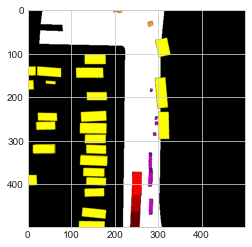

In [15]:
import matplotlib.pyplot as plt

instance_token, sample_token = challenges[6220].split('_')
img = mtp_input_representation.make_input_representation(instance_token, sample_token)
plt.imshow(img)